<a href="https://colab.research.google.com/github/MarcoSuarezECCI/SeminarioBigData/blob/main/AI_Prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predicción de casos de dengue Atlantico

## Librerias

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import drive

##------------- Librerias Machine Learning

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.metrics import mean_absolute_error as MAE
import pickle


#------------------ instalación de lightGBM
!pip install lightgbm
import lightgbm as lgb
#------------------ instalación de RandomForest
from sklearn.ensemble import RandomForestRegressor
#------------------ instalación de XGBoost
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from sklearn.metrics import classification_report

## Obtención de la información

In [8]:
drive.mount('/content/drive', force_remount=True)

file = '/content/drive/MyDrive/data/Articulo/Procesados/Datos_Dengue_Procesado.xlsx'

data = pd.read_excel(file)
print(data.shape)
data.head()

Mounted at /content/drive
(16648, 16)


,consecutivo,fechaNotificacion,semana,anio,edad,sexo,estrato,fechaNacimiento,estadoCaso,nombreUnidad,pais,evento,departamento,municipio,grupoEtario,anio_semana
0,8563847,2021-09-21,37,2021,5,F,2,2015-10-27,Confirmado por laboratorio,MIRED BARRANQUILLA SEDE CAMINO MURILLO,COLOMBIA,DENGUE,ATLANTICO,BARRANQUILLA,primeraInfancia,202137
1,8563848,2021-11-23,46,2021,5,F,3,2015-12-03,Confirmado por laboratorio,SANITAS URGENCIAS BAJA COMPLEJIDAD,COLOMBIA,DENGUE,ATLANTICO,BARRANQUILLA,primeraInfancia,202146
2,8563820,2022-01-02,52,2021,19,M,2,2002-07-08,Confirmado por laboratorio,MIRED BARRANQUILLA SEDE CAMINO MURILLO,COLOMBIA,DENGUE,ATLANTICO,BARRANQUILLA,juventud,202152
3,8563822,2021-09-23,37,2021,19,M,2,2002-04-12,Confirmado por laboratorio,ESE HOSPITAL DE MALAMBO,COLOMBIA,DENGUE,ATLANTICO,MALAMBO,juventud,202137
4,8563823,2021-10-22,37,2021,19,M,3,2002-05-25,Confirmado por laboratorio,CLINICA DEL CARMEN,COLOMBIA,DENGUE,ATLANTICO,BARRANQUILLA,juventud,202137


## Verificar el tipo de datos

In [13]:
data.dtypes

consecutivo           int64
fechaNotificacion    object
semana                int64
anio                  int64
edad                  int64
sexo                 object
estrato              object
fechaNacimiento      object
estadoCaso           object
nombreUnidad         object
pais                 object
evento               object
departamento         object
municipio            object
grupoEtario          object
anio_semana           int64
dtype: object

Establecer las columnas de valor

In [15]:
datac = data
datac = datac.drop([
    #'consecutivo',
    'fechaNotificacion','edad','sexo','estrato','fechaNacimiento','estadoCaso','nombreUnidad','pais','evento','departamento','municipio'
    ], axis=1)
datac.shape
datac.head()

,consecutivo,semana,anio,grupoEtario,anio_semana
0,8563847,37,2021,primeraInfancia,202137
1,8563848,46,2021,primeraInfancia,202146
2,8563820,52,2021,juventud,202152
3,8563822,37,2021,juventud,202137
4,8563823,37,2021,juventud,202137


In [16]:
datacc = datac.groupby(['anio_semana', 'grupoEtario']).size().reset_index(name='conteo')

datacc.head()

,anio_semana,grupoEtario,conteo
0,20211,adolescencia,20
1,20211,adultez,4
2,20211,infancia,28
3,20211,juventud,6
4,20211,personaMayor,2


In [21]:
datacc[['anio_semana', 'conteo']].head()

,anio_semana,conteo
0,20211,20
1,20211,4
2,20211,28
3,20211,6
4,20211,2


## Histogramas

Text(0.5, 1.0, '$grupoEtario$')

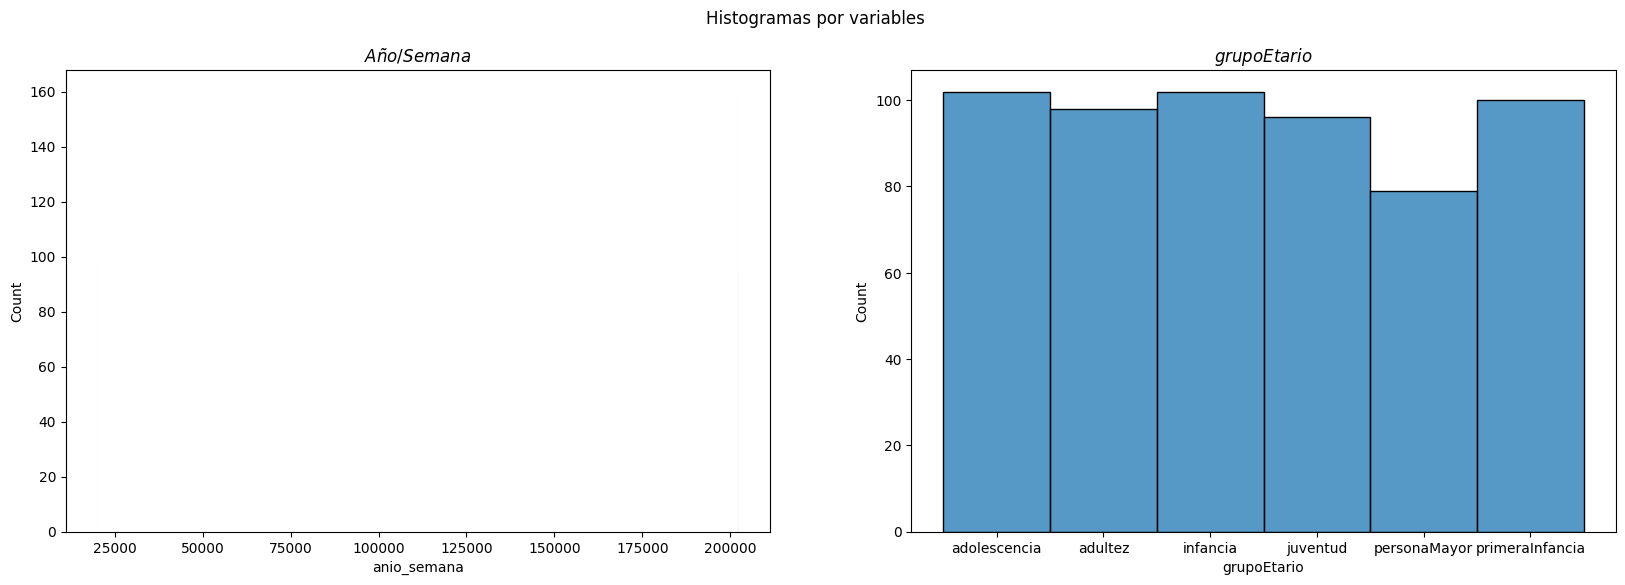

In [20]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
fig.suptitle('Histogramas por variables')
sns.histplot(datacc['anio_semana'], ax=ax1)
ax1.set_title('$Año/Semana$')
sns.histplot(datacc['grupoEtario'], ax=ax2)
ax2.set_title('$grupoEtario$')
#sns.histplot(datacc['anio','semana'], ax=ax3)
#ax3.set_title('$semana$')

## Categorización

In [22]:
datacc['grupoEtario'] = datacc['grupoEtario'].astype('category')
datacc.dtypes
datacc['grupoEtario']  = pd.Categorical(datacc['grupoEtario']).codes
datacc.head()

,anio_semana,grupoEtario,conteo
0,20211,0,20
1,20211,1,4
2,20211,2,28
3,20211,3,6
4,20211,4,2


Text(0.5, 1.0, '$Grupo Etario$')

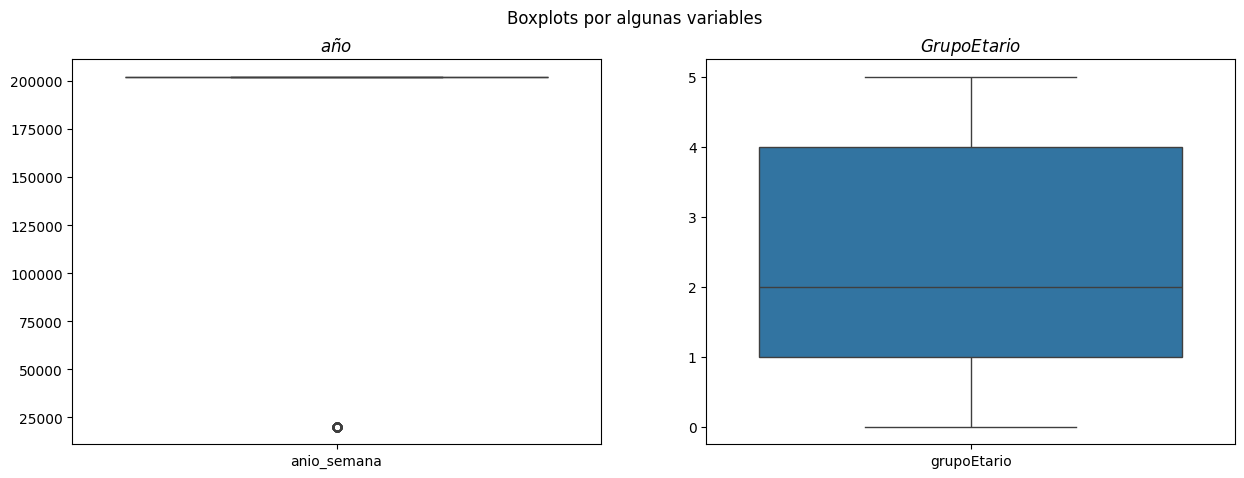

In [24]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Boxplots por algunas variables')
sns.boxplot(data=datacc[['anio_semana']], ax=ax1)
sns.boxplot(data=datacc[['grupoEtario']], ax=ax2)
ax1.set_title('$año$')
ax2.set_title('$Grupo Etario$')
#sns.boxplot(data=datacc[['kms']], ax=ax3)

## Particionamiento de datos

In [25]:
X = datacc.copy()
X = X.drop(['conteo'], axis=1)
print(X.shape)

Y = pd.DataFrame()
Y = datacc['conteo']
print(Y.shape)

(577, 2)
(577,)


In [26]:
# Data set normalization and partitioning
sc = StandardScaler()
Xsc = sc.fit(X)
Xt = Xsc.transform(X)
Xt.shape

(577, 2)

In [27]:
X_train, X_test, y_train, y_test = split(Xt,Y,
                                         test_size=0.20,
                                         random_state=42)

## Random Forest

In [29]:
model3 = RandomForestRegressor()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

In [30]:
# accuracy check
rmse = MSE(y_test, y_pred3, squared=False)
mae = MAE(y_test, y_pred3)
r2 = r2_score(y_test, y_pred3)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

RMSE: 7.60
MAE: 5.04
R2: 0.95


## XGBoost

In [31]:
#Define model
model4 = xgb.XGBRegressor(objective ='reg:squarederror',
                          booster='gbtree',
                          colsample_bytree = 1,
                          importance_type='gain',
                          learning_rate = 0.2,
                          max_depth = 5,
                          alpha = 5,
                          n_estimators = 200,
                          seed=123)

In [32]:
#Training
model4.fit(X_train, y_train)#,
#         eval_set=[(X_train, y_train), (X_test, y_test)], \
#         eval_metric='mlogloss', verbose=False)

XGBRegressor(alpha=5, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
#K-fold cross validation
scores = cross_val_score(model4, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.93


In [34]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model4, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.92


In [35]:
# Pred
y_pred4 = model4.predict(X_test)

In [36]:
# accuracy check
rmse = MSE(y_test, y_pred4, squared=False)
mae = MAE(y_test, y_pred4)
r2 = r2_score(y_test, y_pred4)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

RMSE: 7.81
MAE: 5.30
R2: 0.95


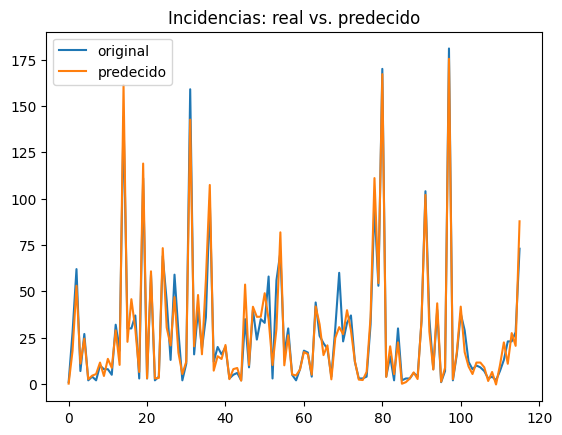

In [44]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred4, label="predecido")
plt.title("Incidencias: real vs. predecido")
plt.legend()
plt.show()

## Light GBM

In [40]:
# Hyperparameters
params = {
    'task': 'train',
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': {'l2','l1'},
    'header' : 'true',
    'verbose': 0
}

# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# fitting the model
model2 = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)
# Pred
y_pred2 = model2.predict(X_test)

In [41]:
# accuracy check
rmse = MSE(y_test, y_pred2, squared=False)
mae = MAE(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

RMSE: 14.38
MAE: 9.62
R2: 0.83


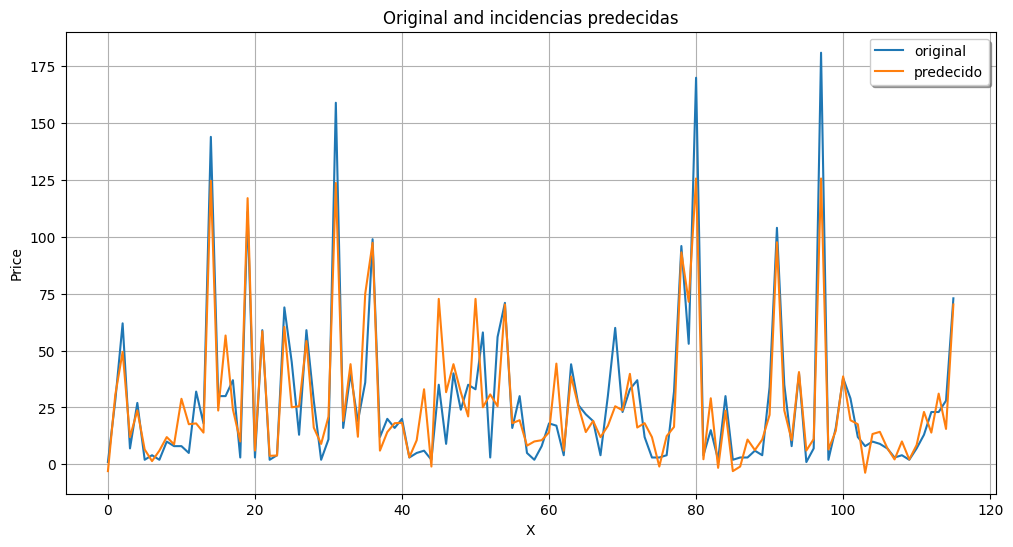

In [45]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred2, label="predecido")
plt.title("Original and incidencias predecidas")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()